In [ ]:
%matplotlib inline
from load_data import load, load_and_normalize_by_individual
from plots import plot_clusters
import numpy as np
import jax.numpy as jnp
from VarGMM import *
from cluster import reduce_to_threshold
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as snb
from mpl_toolkits.mplot3d import Axes3D  
from plots import plot_clusters

snb.set_style('darkgrid')
colors = snb.color_palette()
snb.set_theme(font_scale=1.1)


In [13]:
# N = 20 #Components for clustering

raw_data, metadata = load("data/HR_data_2.csv", cohort="D1_2")

# raw_data = raw_data[raw_data['Phase']=='phase3']
phase_values = raw_data['Phase'].to_numpy()  # <-- Save Phase values separately
raw_data = raw_data.drop(labels='Phase', axis=1)
 #One hot encode instructor?
data, _ = reduce_to_threshold(raw_data, threshold=0.85)

data = data.to_numpy()
data = jnp.array(data)

data=data[:,:2] #two dimensional clustering only?
puzzler_vals = np.array(metadata['Puzzler'][:data.shape[0]])

raw_data = raw_data.to_numpy()
raw_data = jnp.array(raw_data)

print(data.shape)
D = data.shape[1]
D_raw = raw_data.shape[1]

(72, 2)


c:\Users\malth\Documents\DTU\Master\Første Semester\Computational Data Analysis\02582_case_2\load_data.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode[0], inplace=True)
c:\Users\malth\Documents\DTU\Master\Første Semester\Computational Data Analysis\02582_case_2\load_data.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

In [18]:
vi = VariationalGMM(D=D, K=2, alpha0=0.1, beta0 = 1)   
vi.fit(data.squeeze(), max_itt=10000, seed=2)

# vi_raw = VariationalGMM(D=D_raw, K=3, alpha0=0.01, beta0 = 0.1)   
# vi_raw.fit(raw_data.squeeze(), max_itt=10000, seed=2)

Converged in   64 iterations for K =  2 with lowerbound = -382.532. Time = 2.07


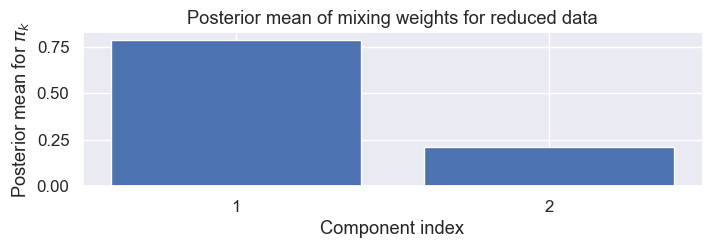

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.bar(jnp.arange(1, vi.K+1), vi.pi)
ax.set(xlabel='Component index', ylabel='Posterior mean for $\\pi_k$', title='Posterior mean of mixing weights for reduced data', xticks=jnp.linspace(1, vi.K, min(vi.K, 20)).round());

# fig, ax = plt.subplots(1, 1, figsize=(8, 2))
# ax.bar(jnp.arange(1, vi_raw.K+1), vi_raw.pi)
# ax.set(xlabel='Component index', ylabel='Posterior mean for $\\pi_k$', title='Posterior mean of mixing weights for raw data', xticks=jnp.linspace(1, vi_raw.K, min(vi_raw.K, 20)).round());

In [20]:
def print_results(clusters, metadata, metadata_vals, type):
    print(f"\nResults of type: {type}")
    # Initialize count matrix
    counts = np.zeros((len(clusters), len(metadata)), dtype=int)

    # Fill the matrix
    for i, cluster in enumerate(clusters):
        for j, m in enumerate(metadata):
            counts[i, j] = np.sum((ztrain == cluster) & (metadata_vals == m))

    # Print nicely
    for i, cluster in enumerate(clusters):
        print(f"\nCluster {cluster}:")
        for j, m in enumerate(metadata):
            print(f"{counts[i, j]} points")


def three_d_plot_data(data, labels, phase=None):
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    
    num_classes = np.unique(labels)
    cmap = plt.get_cmap('tab10')

    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # marker styles
    unique_phases = np.unique(phase) if phase is not None else [None]

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    for cls in num_classes:
        for i, ph in enumerate(unique_phases):
            idx = (labels == cls)
            if phase is not None:
                idx = idx & (phase == ph)
            marker = markers[i % len(markers)]
            ax.scatter(x[idx], y[idx], z[idx], 
                       color=cmap(cls), marker=marker, edgecolors='black', s=50)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Make custom legend for phase (markers only)
    from matplotlib.lines import Line2D

    legend_elements = []
    for i, ph in enumerate(unique_phases):
        legend_elements.append(
            Line2D([0], [0], marker=markers[i % len(markers)], color='black', linestyle='None',
                   markersize=10, label=f'{ph}')
        )

    ax.legend(handles=legend_elements, title="Phase", loc='best')
    plt.show()



ptrain = vi.compute_component_probs(data)
ztrain = jnp.argmax(ptrain, axis=1)
clusters = np.unique(ztrain)

phase_classes = np.unique(phase_values[:data.shape[0]])
phase_vals = np.array(phase_values[:data.shape[0]])

puzzler_classes = np.unique(puzzler_vals)



print_results(clusters, phase_classes, phase_vals, type="Phases")

puzzler_classes = np.unique(metadata['Puzzler'][:data.shape[0]])
puzzler_vals = np.array(metadata['Puzzler'][:data.shape[0]])

print_results(clusters, puzzler_classes, puzzler_vals, type="Puzzler")



Results of type: Phases

Cluster 0:
20 points
19 points
19 points

Cluster 1:
4 points
5 points
5 points

Results of type: Puzzler

Cluster 0:
36 points
22 points

Cluster 1:
0 points
14 points


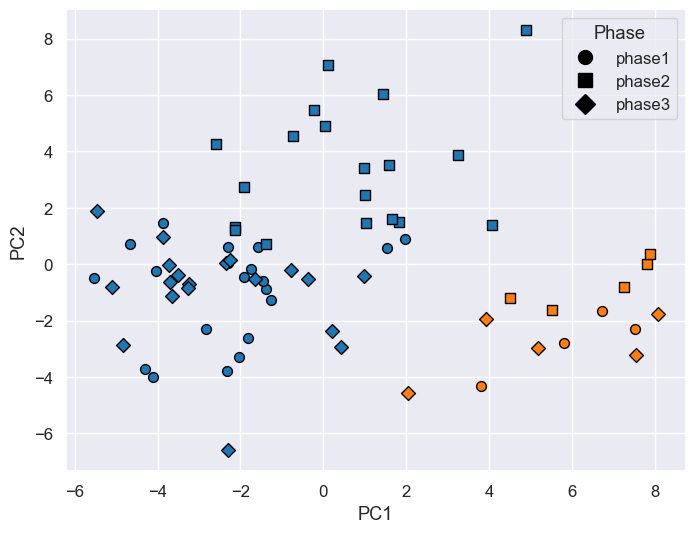

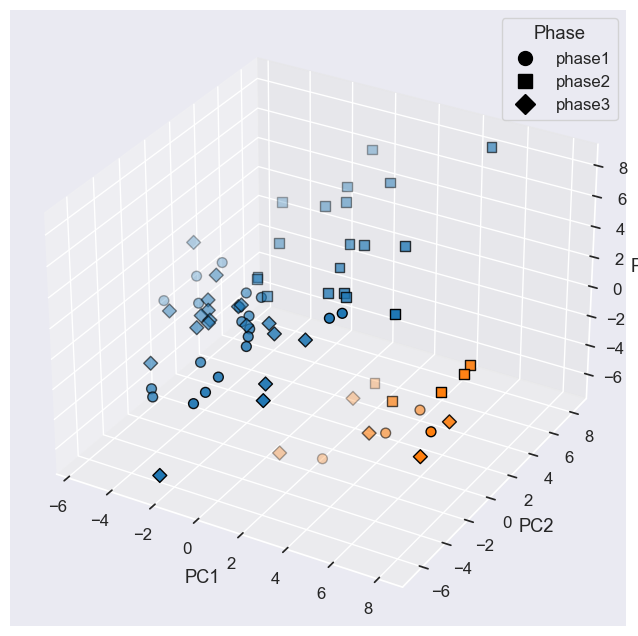

For the reduced data, the silhoutte score is: 0.4943086802959442


In [21]:
plot_clusters(data, ztrain, phase=phase_values[:data.shape[0]])
three_d_plot_data(data, ztrain, phase=phase_values[:data.shape[0]])

print(f"For the reduced data, the silhoutte score is: {silhouette_score(data, ztrain)}")